## 问题定义

问题定义如下图，矩形求解区域，长宽为0.1m，上侧面为从左至右的1m/s的滑移边界，其他三个侧面为无滑移边界。雷诺数为10。
![Problem](./resource/problem_define.png)

对待求解问题的数学描述如下：
![Equation](./resource/equation.png)

其中，$u,v$分别为x方向速度，y方向速度，$p$为压强，$\nu,\rho$分别为运动粘度和密度。在本求解中定义$\nu=0.01$，$\rho=1.0$

### 求解目标

给定坐标$(x,y)$求解稳态结果（$u,v, p$）


## 求解

In [1]:
import os
import warnings

# optional
# set appropriate GPU in case of multi-GPU machine
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [2]:
# 必要的符号运算
from sympy import Symbol, Eq, Abs

import modulus.sym

# 超参数
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra import to_absolute_path, instantiate_arch, ModulusConfig
from modulus.sym.hydra.utils import compose

# 求解器
from modulus.sym.solver import Solver

# domain
from modulus.sym.domain import Domain

# 几何物体
from modulus.sym.geometry.primitives_2d import Rectangle

# 约束
from modulus.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)

# validator
from modulus.sym.domain.validator import PointwiseValidator

# inferencer
from modulus.sym.domain.inferencer import PointwiseInferencer
from modulus.sym.key import Key

# Equation
from modulus.sym.eq.pdes.navier_stokes import NavierStokes

# post process
from modulus.sym.utils.io import (
    csv_to_dict,
    ValidatorPlotter,
    InferencerPlotter,
)
import matplotlib.pyplot as plt

### ModulusConfig or compose

在一般的python script中，通常会使用ModulusConfig解析参数并具有如下的基本框架

```python
import modulus.sym
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra.config import ModulusConfig

@modulus.main(config_path="conf", config_name="config")
def run(cfg: ModulusConfig) -> None:
    print(to_yaml(cfg))

if __name__ == "__main__":
   run()

```

但是这一框架不大适合jupyter模式，原因在于上述框架对参数的解析以及传递是包裹形式的，不适合交互式编程。因此，在jupyter中更常用compose进行参数解析：

```python
import modulus.sym
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra.utils import compose
from modulus.sym.hydra.config import ModulusConfig

cfg = compose(config_path="conf", config_name="config")
cfg.network_dir = 'outputs'    # Set the network directory for checkpoints
print(to_yaml(cfg))

```
即直接解析参数，不使用一般的hydra运行模式

In [3]:
cfg = compose(config_path="conf", config_name="config")
cfg.network_dir = 'outputs'    # Set the network directory for checkpoints
print(to_yaml(cfg))

/usr/local/lib/python3.10/dist-packages/modulus/sym/hydra/utils.py:148: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(


training:
  max_steps: 10000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: 1000
  rec_inference_freq: 2000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  amp: false
  amp_dtype: float16
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
graph:
  func_arch: true
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs
initialization_network_dir: ''
save_filetypes: vtk,npz
summary_histograms: false
jit: true
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_graphs: true
cuda_graph_warmup: 20
find_unused_parameters: false
broadcast_buffers: false
device: ''
debug: false
run_mode: train
arch:
  fully_connected:
    arch_type: fully_connected
    input_keys: ???
  

### 定义必要组件

#### PDE

In [4]:
ns = NavierStokes(nu=0.01, rho=1.0, dim=2, time=False)

#### Model

In [5]:

# 定义简单的全连接网络
# 输入为坐标x和y
# 输出为两个方向的速度u,v以及压强p
flow_net = instantiate_arch(
        input_keys=[Key("x"), Key("y")],
        output_keys=[Key("u"), Key("v"), Key("p")],
        cfg=cfg.arch.fully_connected,
    )
print(flow_net)

# 创建node集合
nodes = ns.make_nodes() + [flow_net.make_node(name="flow_network")]

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=2, out_features=512, bias=True)
      )
      (1-5): 5 x FCLayer(
        (linear): WeightNormLinear(in_features=512, out_features=512, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=512, out_features=3, bias=True)
    )
  )
)


#### Geo

In [6]:
# 长宽均为1的矩形
height = 0.1
width = 0.1
x, y = Symbol("x"), Symbol("y")
rec = Rectangle((-width / 2, -height / 2), (width / 2, height / 2))

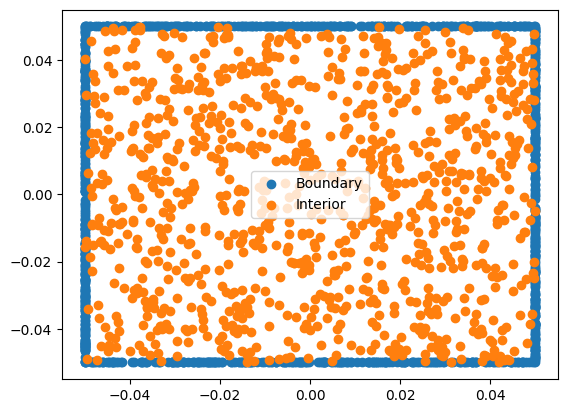

In [7]:
# 通过采样样本点能够可视化求解域的边界

boundary_samples = rec.sample_boundary(1000)
interior_samples = rec.sample_interior(1000)

plt.figure()
plt.scatter(boundary_samples['x'], boundary_samples['y'], label='Boundary')
plt.scatter(interior_samples['x'], interior_samples['y'], label='Interior')
plt.legend()
plt.show()

#### Domain

在Domain中定义约束以及训练所需的各种组件

In [8]:
# make ldc domain
ldc_domain = Domain()

四个边界条件

In [9]:
# 顶部滑移边界
# 水平速度为1.0，垂直速度为0
# 注意lambda_weighting参数，这个参数定义了样本权重，在本示例中，约靠近边界，样本的权重越小
# criteria定义了采样的位置
# outvar定义了边界条件

# 注意总点数
# 这里的batch_size定义了每一个batch的采样数，
# 此外还有一个参数是batch_per_epoch (default: 1000)
# 实际的总采样数为batch_per_epoch * batch_size
top_wall = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"u": 1.0, "v": 0},
    batch_size=cfg.batch_size.TopWall,
    lambda_weighting={"u": 1.0 - 20 * Abs(x), "v": 1.0},  # weight edges to be zero
    criteria=Eq(y, height / 2),
)
ldc_domain.add_constraint(top_wall, "top_wall")

# 左右以及下侧的无滑移边界
no_slip = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"u": 0, "v": 0},
    batch_size=cfg.batch_size.NoSlip,
    criteria=y < height / 2,
)
ldc_domain.add_constraint(no_slip, "no_slip")

内部满足PDE约束

In [10]:
# interior
# 由于本求解中NS方程直接调用的模型，所以这里outvar直接使用了对应的key
# 具体定义可参考modulus/eq/pdes/navier_stokes.py
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"continuity": 0, "momentum_x": 0, "momentum_y": 0},
    batch_size=cfg.batch_size.Interior,
    lambda_weighting={
        "continuity": Symbol("sdf"),
        "momentum_x": Symbol("sdf"),
        "momentum_y": Symbol("sdf"),
    },
)
ldc_domain.add_constraint(interior, "interior")

验证器以及其他必要组件

In [11]:
# 数据目录
file_path = "openfoam/cavity_uniformVel0.csv"
if os.path.exists(to_absolute_path(file_path)):
    mapping = {"Points:0": "x", "Points:1": "y", "U:0": "u", "U:1": "v", "p": "p"}
    openfoam_var = csv_to_dict(to_absolute_path(file_path), mapping)
    openfoam_var["x"] += -width / 2  # center OpenFoam data
    openfoam_var["y"] += -height / 2  # center OpenFoam data
    
    # 输入数据
    openfoam_invar_numpy = {
        key: value for key, value in openfoam_var.items() if key in ["x", "y"]
    }
    # 输出数据
    openfoam_outvar_numpy = {
        key: value for key, value in openfoam_var.items() if key in ["u", "v"]
    }
    
    # 创建validator
    openfoam_validator = PointwiseValidator(
        nodes=nodes,
        invar=openfoam_invar_numpy,
        true_outvar=openfoam_outvar_numpy,
        batch_size=1024,
        plotter=ValidatorPlotter(),
    )
    ldc_domain.add_validator(openfoam_validator)

    # 创建inferencer
    grid_inference = PointwiseInferencer(
        nodes=nodes,
        invar=openfoam_invar_numpy,
        output_names=["u", "v", "p"],
        batch_size=1024,
        plotter=InferencerPlotter(),
    )
    ldc_domain.add_inferencer(grid_inference, "inf_data")
else:
    warnings.warn(
        f"Directory {file_path} does not exist. Will skip adding validators. Please download the additional files from NGC https://catalog.ngc.nvidia.com/orgs/nvidia/teams/modulus/resources/modulus_sym_examples_supplemental_materials"
    )

### 求解器以及求解

In [12]:
# 定义求解器
slv = Solver(cfg, ldc_domain)

手动加载日志系统

In [13]:
import logging
logging.getLogger().addHandler(logging.StreamHandler())

启动求解

In [14]:
slv.solve()

Installed PyTorch version 2.2.0a0+81ea7a4 is not TorchScript supported in Modulus. Version 2.1.0a0+4136153 is officially supported.
attempting to restore from: /workspace/2D_LDC/outputs
Success loading optimizer: /workspace/2D_LDC/outputs/optim_checkpoint.0.pth
Success loading model: /workspace/2D_LDC/outputs/flow_network.0.pth
[step:      10000] saved constraint results to outputs
[step:      10000] record constraint batch time:  7.330e-02s
locator: <matplotlib.ticker.AutoLocator object at 0x7fea8adc0ee0>
locator: <matplotlib.ticker.AutoLocator object at 0x7fea8b08ebf0>
locator: <matplotlib.ticker.AutoLocator object at 0x7fea8b0d83a0>
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: scor

findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matp

### 后处理以及可视化

对于jupyter，比较方便的方法是使用matplotlib

此外，还可以使用tensorboard以及Paraview

如果使用了PointwiseValidator则可以直接查看验证的结果：

![u](./outputs/validators/validator_u.png)
![v](./outputs/validators/validator_v.png)